In [1]:
import torch
import torchvision

from torchvision import models
import transformers
from transformers import CvtModel, AutoImageProcessor

import src.datasets.deep_fashion_ctsrbm

import os
import pathlib

import numpy as np

from datasets import load_dataset

from tqdm.notebook import tqdm

---

In [2]:
model = CvtModel.from_pretrained("microsoft/cvt-21")

In [3]:
with open("misc/cvt-21_model_arch.txt", "w") as out_file:
    print(model, file=out_file)

---

In [4]:
model = CvtModel.from_pretrained("microsoft/cvt-21")

In [5]:
ctsrbm_image_transform = AutoImageProcessor.from_pretrained("microsoft/cvt-21")
ctsrbm_image_transform_corr = lambda t: ctsrbm_image_transform(t, return_tensors="pt").pixel_values[0]
ctsrbm_dataset_dir = os.path.join(pathlib.Path.home(), "data", "DeepFashion", "Consumer-to-shop Clothes Retrieval Benchmark")
ctsrbm_dataset = src.datasets.deep_fashion_ctsrbm.ConsToShopClothRetrBmkImageLoader(ctsrbm_dataset_dir, ctsrbm_image_transform_corr)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
ctsrbm_image_transform

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [7]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

model.encoder.stages[0].register_forward_hook(get_activation('encoder.stages[0]'))
model.encoder.stages[0].embedding.register_forward_hook(get_activation('encoder.stages[0].embedding'))
model.encoder.stages[1].register_forward_hook(get_activation('encoder.stages[1]'))
model.encoder.stages[1].embedding.register_forward_hook(get_activation('encoder.stages[1].embedding'))
model.encoder.stages[2].register_forward_hook(get_activation('encoder.stages[2]'))
model.encoder.stages[2].embedding.register_forward_hook(get_activation('encoder.stages[2].embedding'))
model.encoder.stages.register_forward_hook(get_activation('encoder.stages'))
model.encoder.register_forward_hook(get_activation('encoder'))

In [8]:
input = ctsrbm_dataset[0][0][None, :]
output = model(input)

In [9]:
print(output.last_hidden_state.shape)
print(output.cls_token_value.shape)

torch.Size([1, 384, 14, 14])
torch.Size([1, 1, 384])


In [10]:
print("{:40s}".format("input"))
print("    {:}".format(type(input)))
print("    {:}".format(input.shape))

print()

print("{:40s}".format("output.last_hidden_state"))
print("    {:}".format(type(output.last_hidden_state)))
print("    {:}".format(output.last_hidden_state.shape))

print()
print("---")
print()

for key, item in activation.items():
    print("{:40s}".format(key))
    print("    {:}".format(type(item)))

    if type(item) is tuple:
        print("    Num items: {:d}".format(len(item)))
        for item_idx, item_el in enumerate(item):
            print("    Item {:d}:".format(item_idx))
            print("        {:}".format(type(item_el)))
            if type(item_el) is torch.Tensor:
                print("        {:}".format(item_el.shape))

    if type(item) is torch.Tensor:
        print("    {:}".format(item.shape))

    if type(item) is transformers.models.cvt.modeling_cvt.BaseModelOutputWithCLSToken:
        print("    last_hidden_state:")
        print("        {:}".format(item.last_hidden_state.shape))

    print()

input                                   
    <class 'torch.Tensor'>
    torch.Size([1, 3, 224, 224])

output.last_hidden_state                
    <class 'torch.Tensor'>
    torch.Size([1, 384, 14, 14])

---

encoder.stages[0].embedding             
    <class 'torch.Tensor'>
    torch.Size([1, 64, 56, 56])

encoder.stages[0]                       
    <class 'tuple'>
    Num items: 2
    Item 0:
        <class 'torch.Tensor'>
        torch.Size([1, 64, 56, 56])
    Item 1:
        <class 'NoneType'>

encoder.stages[1].embedding             
    <class 'torch.Tensor'>
    torch.Size([1, 192, 28, 28])

encoder.stages[1]                       
    <class 'tuple'>
    Num items: 2
    Item 0:
        <class 'torch.Tensor'>
        torch.Size([1, 192, 28, 28])
    Item 1:
        <class 'NoneType'>

encoder.stages[2].embedding             
    <class 'torch.Tensor'>
    torch.Size([1, 384, 14, 14])

encoder.stages[2]                       
    <class 'tuple'>
    Num items: 2
    Item 0:
 

---

In [ ]:
model = CvtModel.from_pretrained("microsoft/cvt-21")

In [ ]:
last_feature_l = 0
last_feature_hw = 0

for size in tqdm(range(3, 512 + 1)):

    model_input = torch.rand(1, 3, size, size)
    model_output = model(model_input)

    feature_l = model_output.last_hidden_state.size(1)
    feature_hw = model_output.last_hidden_state.size(3)

    if last_feature_l < feature_l or last_feature_hw < feature_hw:
        print("{:3d} {:3d} {:3d}".format(size, feature_l, feature_hw))
        last_feature_l = feature_l
        last_feature_hw = feature_hw

  0%|          | 0/510 [00:00<?, ?it/s]

  3 384   1
 19 384   2
 35 384   3
 51 384   4
 67 384   5
 83 384   6
 99 384   7
115 384   8
131 384   9
147 384  10
163 384  11
179 384  12
195 384  13
211 384  14
227 384  15
243 384  16
259 384  17
275 384  18
291 384  19
307 384  20
323 384  21
339 384  22
355 384  23
371 384  24
387 384  25
403 384  26
419 384  27
435 384  28
451 384  29
467 384  30
483 384  31
499 384  32


In [95]:
for size in tqdm(range(3, 512 + 1)):

    model_input = torch.rand(1, 3, size, size)
    model_output = model(model_input)

    perm_size = model_output.last_hidden_state.size(3)
    
    theo_perm_size = (size + 13) // 16

    if perm_size != theo_perm_size:
        print(size, perm_size, theo_perm_size)

  0%|          | 0/510 [00:00<?, ?it/s]

---

In [11]:
import src.comps.backbones_trf

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
model = src.comps.backbones_trf.CvT21Backbone(
    pretrn_name="microsoft/cvt-21",
    img_size=224
    )

In [13]:
model_image_transform = model.get_image_transform()
ctsrbm_dataset_dir = os.path.join(pathlib.Path.home(), "data", "DeepFashion", "Consumer-to-shop Clothes Retrieval Benchmark")
ctsrbm_dataset = src.datasets.deep_fashion_ctsrbm.ConsToShopClothRetrBmkImageLoader(ctsrbm_dataset_dir, model_image_transform)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [14]:
input = ctsrbm_dataset[0][0][None, :]
output = model(input)

In [15]:
def show_data_ConsToShopClothRetrBmkImageLoader(idx):

    image, item_id = ctsrbm_dataset[idx]

    image_copy = image

    if type(image) == torch.Tensor:
        image_copy = image_copy.permute(1, 2, 0)

    vmax = image_copy.max().item()
    vmin = image_copy.min().item()

    image_copy = (image_copy - vmin) / (vmax - vmin)

    plt.imshow(image_copy)
    
    title_lines = []
    title_lines.append("Image ID: {:d}".format(idx))
    title_lines.append("Item ID: {:d}".format(item_id))
    title_lines.append("Size: " + str(image_copy.size()))
    plt.title("\n".join(title_lines))

    plt.show()

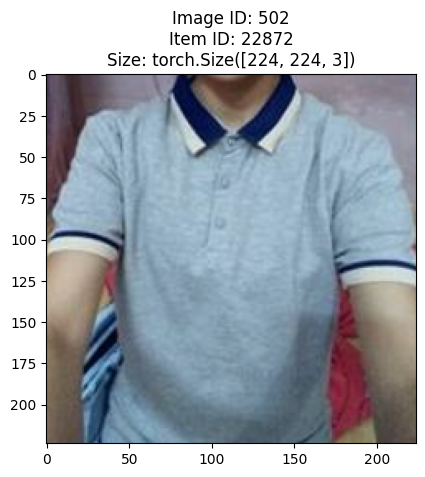

In [16]:
show_data_ConsToShopClothRetrBmkImageLoader(502)